# Load libraries

In [1]:
library(dplyr)
library(lubridate)
library(httr)
library(isotree)
library(leaflet)
library(rnaturalearth)
library(rnaturalearthdata)
library(IRdisplay)
library(htmlwidgets)
library(pROC)   # For ROC Curve
library(caret)  # For precision, recall, F1, accuracy
library(leaflet.extras) # For clustering dots
library(ggplot2)
library(yardstick)
library(PRROC)  # For Precision-Recall curve
library(reshape2) # For Confusion Matrix heatmap
library(patchwork) # For combining plots


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'rnaturalearthdata'


The following object is masked from 'package:rnaturalearth':

    countries110


Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var


Loading required package: ggplot2

Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:httr':

    progress



Attaching package: 'yardstick'


The following objects are masked from 'package:caret':

    precision, recall, sensitivity, specificity


Loading required package: rlang



# Validate Coordinates

In [2]:
validate_coordinates <- function(df) {
  world <- ne_countries(scale = "medium", returnclass = "sf")
  coords <- sf::st_as_sf(df, coords = c("longitude", "latitude"), crs = 4326)
  valid_coords <- sf::st_within(coords, world, sparse = FALSE)
  df <- df[apply(valid_coords, 1, any), ]
  return(df)
}

# Fetch Data

In [3]:
fetch_data <- function() {
  set.seed(123)
  n <- 1000
  df <- data.frame(
    timestamp = Sys.time() + seq(1, n, by = 1),
    request_rate = rpois(n, lambda = 20),
    session_duration = rnorm(n, mean = 300, sd = 50),
    unique_paths_visited = rpois(n, lambda = 5),
    latitude = runif(n, min = -90, max = 90),
    longitude = runif(n, min = -180, max = 180)
  )
  
  fake_traffic_indices <- sample(1:n, size = floor(0.1 * n))
  df$request_rate[fake_traffic_indices] <- rpois(length(fake_traffic_indices), lambda = 100)
  df$session_duration[fake_traffic_indices] <- rnorm(length(fake_traffic_indices), mean = 100, sd = 30)
  df$fake_traffic <- ifelse(1:n %in% fake_traffic_indices, 1, 0)
  
  df <- validate_coordinates(df)
  return(df)
}

# Monitor Traffic

In [4]:
monitor_traffic <- function(new_data, model) {
  new_data <- new_data %>%
    mutate(
      hour = hour(timestamp),
      day_of_week = wday(timestamp, label = TRUE)
    )
  
  new_data$anomaly_score <- predict(model, new_data[, c("request_rate", "session_duration", "unique_paths_visited")])
  new_data$anomaly <- ifelse(new_data$anomaly_score > 0.75, 1, 0)
  new_data$traffic_type <- ifelse(new_data$fake_traffic == 1, "Fake Traffic", "Genuine Traffic")
  return(new_data)
}

# Train Model and Predict

In [5]:
# Fetch and Preprocess
data <- fetch_data()

data <- data %>%
  mutate(
    hour = hour(timestamp),
    day_of_week = wday(timestamp, label = TRUE)
  )

# Train Model
model <- isolation.forest(data[, c("request_rate", "session_duration", "unique_paths_visited")])


# Monitor

In [6]:
monitored_data <- monitor_traffic(data, model)

# Metrics Calculation

In [7]:
# Actual and Predicted Labels
actual <- as.factor(monitored_data$fake_traffic)
predicted <- as.factor(ifelse(monitored_data$anomaly == 1, 1, 0))

# Confusion Matrix
conf_matrix <- confusionMatrix(predicted, actual, positive = "1")
print(conf_matrix)

Warning message in confusionMatrix.default(predicted, actual, positive = "1"):
"Levels are not in the same order for reference and data. Refactoring data to match."


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 291  27
         1   0   0
                                          
               Accuracy : 0.9151          
                 95% CI : (0.8789, 0.9433)
    No Information Rate : 0.9151          
    P-Value [Acc > NIR] : 0.551           
                                          
                  Kappa : 0               
                                          
 Mcnemar's Test P-Value : 5.624e-07       
                                          
            Sensitivity : 0.00000         
            Specificity : 1.00000         
         Pos Pred Value :     NaN         
         Neg Pred Value : 0.91509         
             Prevalence : 0.08491         
         Detection Rate : 0.00000         
   Detection Prevalence : 0.00000         
      Balanced Accuracy : 0.50000         
                                          
       'Positive' Class : 1               
                              

# ROC Curve

Setting levels: control = 0, case = 1

Setting direction: controls < cases



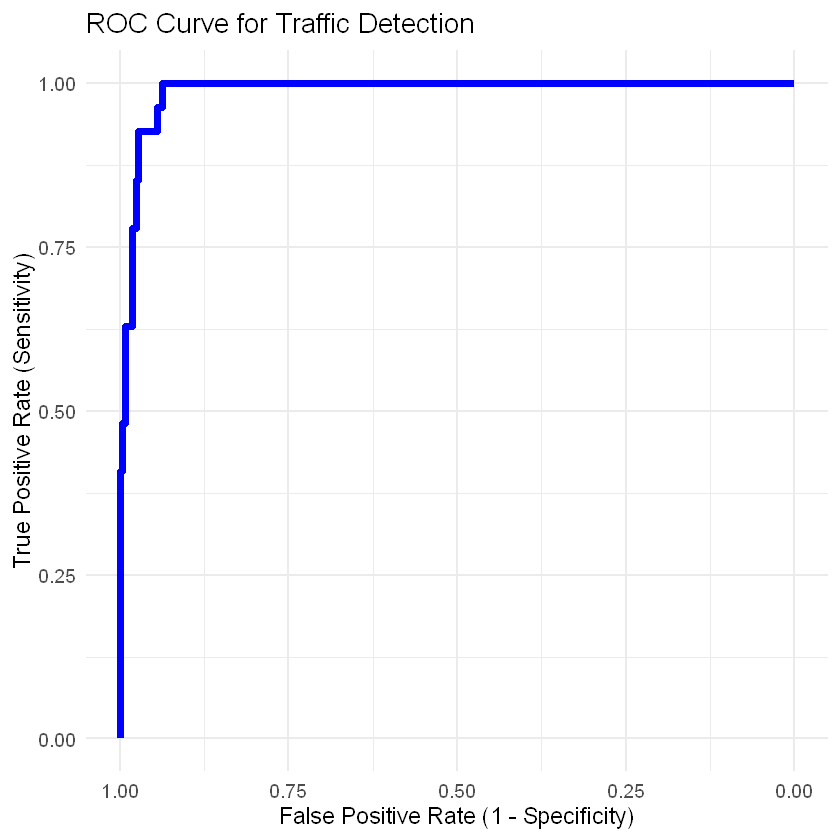

In [8]:
roc_obj <- roc(actual, monitored_data$anomaly_score)
ggroc(roc_obj, colour = "blue", size = 2) +
  ggtitle("ROC Curve for Traffic Detection") +
  xlab("False Positive Rate (1 - Specificity)") +
  ylab("True Positive Rate (Sensitivity)") +
  theme_minimal(base_size = 14)

# Metrics

In [9]:
accuracy <- conf_matrix$overall["Accuracy"]
precision <- conf_matrix$byClass["Pos Pred Value"]
recall <- conf_matrix$byClass["Sensitivity"]
f1_score <- 2 * ((precision * recall) / (precision + recall))
roc_obj <- roc(actual, monitored_data$anomaly_score)  # Pass continuous scores
auc_value <- auc(roc_obj)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



# Print all metrics

In [10]:
cat("Accuracy:", round(accuracy * 100, 2), "%\n")
cat("Precision:", round(precision, 4), "\n")
cat("Recall:", round(recall, 4), "\n")
cat("F1 Score:", round(f1_score, 4), "\n")
cat("AUC (ROC):", round(auc_value, 4), "\n")

Accuracy: 91.51 %
Precision: NaN 
Recall: 0 
F1 Score: NaN 
AUC (ROC): 0.988 


# Plots

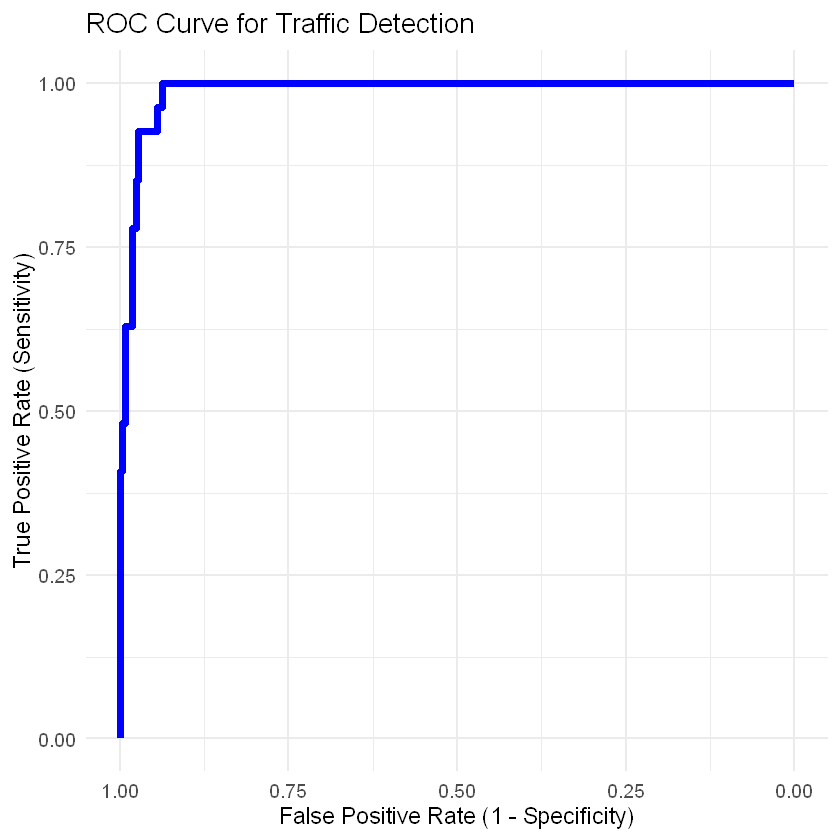

In [11]:
# ROC Curve
roc_plot <- ggroc(roc_obj, colour = "blue", size = 2) +
  ggtitle("ROC Curve for Traffic Detection") +
  xlab("False Positive Rate (1 - Specificity)") +
  ylab("True Positive Rate (Sensitivity)") +
  theme_minimal(base_size = 14)

roc_plot

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


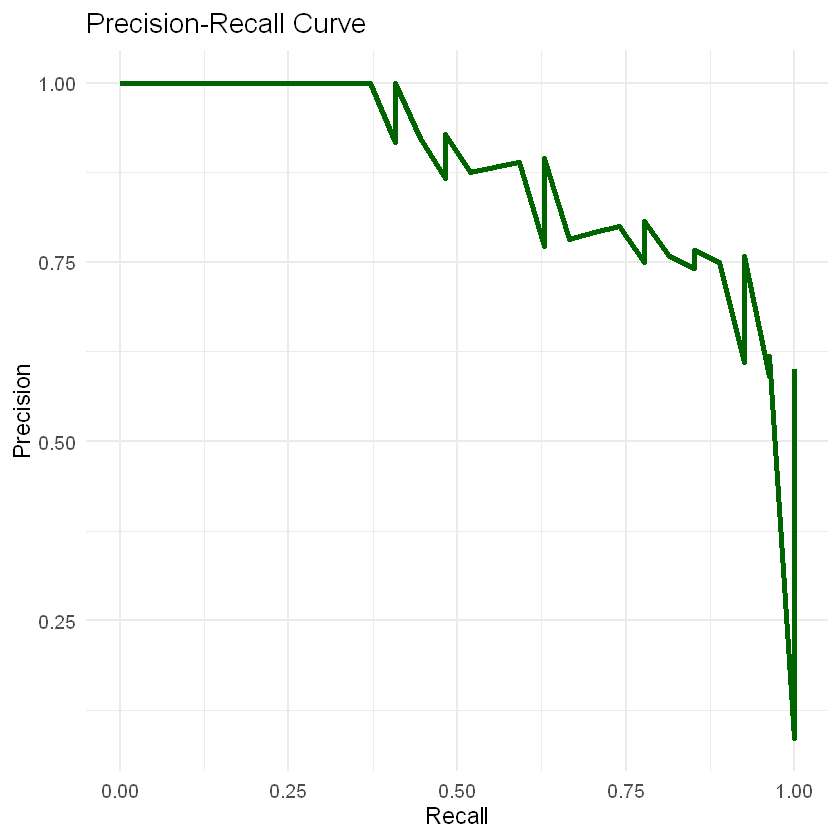

In [12]:
# Precision-Recall Curve
pr <- pr.curve(scores.class0 = monitored_data$anomaly_score[monitored_data$fake_traffic == 1],
               scores.class1 = monitored_data$anomaly_score[monitored_data$fake_traffic == 0],
               curve = TRUE)

pr_plot <- ggplot(data.frame(pr$curve), aes(x = X1, y = X2)) +
  geom_line(color = "darkgreen", size = 1.5) +
  labs(title = "Precision-Recall Curve",
       x = "Recall", y = "Precision") +
  theme_minimal(base_size = 14)

pr_plot

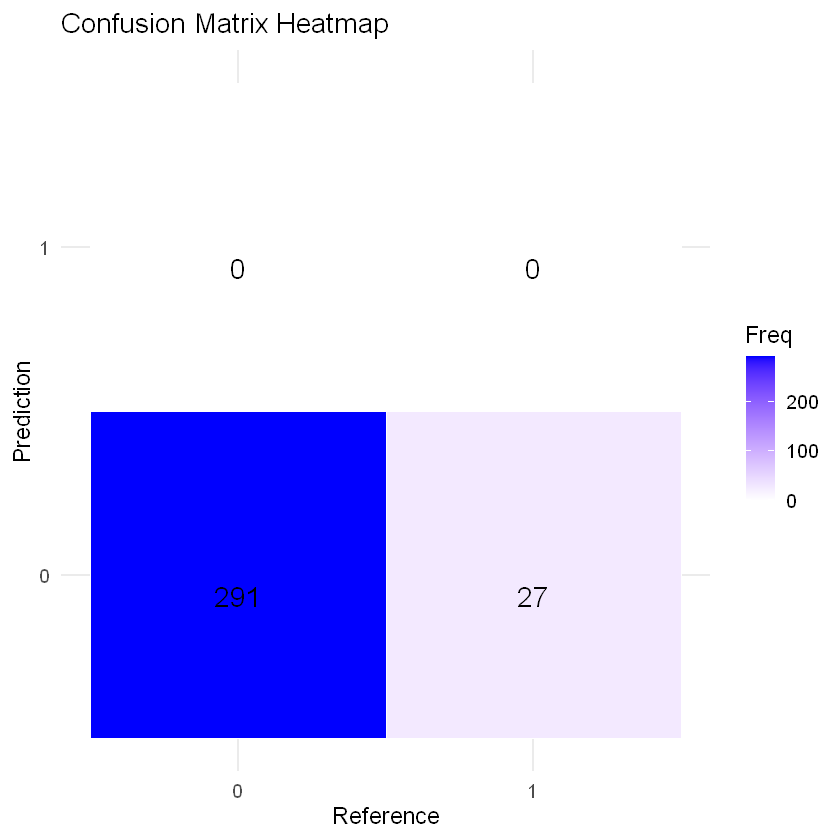

In [13]:
# Confusion Matrix Heatmap
cm_df <- as.data.frame(conf_matrix$table)
colnames(cm_df) <- c("Prediction", "Reference", "Freq")

cm_plot <- ggplot(cm_df, aes(x = Reference, y = Prediction)) +
  geom_tile(aes(fill = Freq), color = "white") +
  scale_fill_gradient(low = "white", high = "blue") +
  geom_text(aes(label = Freq), vjust = 1.5, size = 6) +
  theme_minimal(base_size = 14) +
  labs(title = "Confusion Matrix Heatmap")

cm_plot

In [14]:
# Anomaly Score Distribution
density_plot <- ggplot(monitored_data, aes(x = anomaly_score, fill = traffic_type)) +
  geom_density(alpha = 0.5) +
  labs(title = "Anomaly Score Distribution",
       x = "Anomaly Score", y = "Density") +
  theme_minimal(base_size = 14)


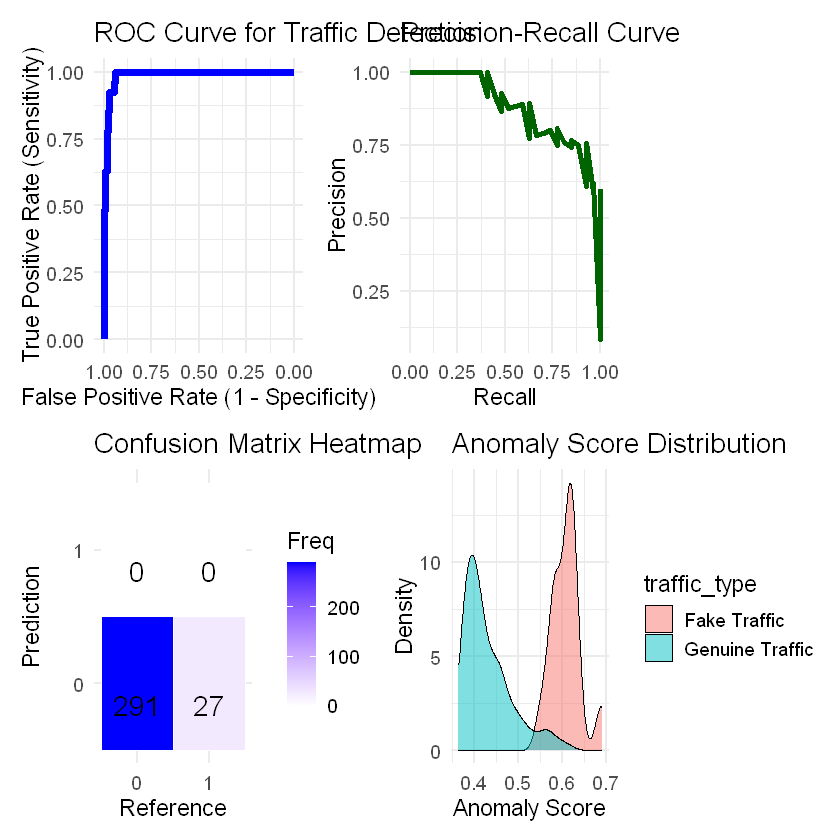

In [15]:
# Combine All Plots
(roc_plot | pr_plot) / (cm_plot | density_plot)

# Create Leaflet Map

In [16]:
# Convert to numeric
monitored_data$latitude <- as.numeric(monitored_data$latitude)
monitored_data$longitude <- as.numeric(monitored_data$longitude)

# Leaflet Map
leaflet_map <- leaflet(data = monitored_data) %>% 
  addProviderTiles(providers$CartoDB.Positron) %>%
  addCircleMarkers(
    lat = ~latitude,
    lng = ~longitude,
    color = ~ifelse(traffic_type == "Fake Traffic", 'red', 'green'),
    label = ~paste(
      "Request Rate:", request_rate, "<br>",
      "Session Duration:", session_duration, "<br>",
      "Unique Paths Visited:", unique_paths_visited, "<br>",
      "Traffic Type:", traffic_type
    ),
    radius = ~ifelse(traffic_type == "Fake Traffic", 8, 4),
    clusterOptions = markerClusterOptions(),
    stroke = FALSE,
    fillOpacity = 0.7
  )

# Display & Save Map

In [17]:
# Display Map
print(leaflet_map)

# Save Map
saveWidget(leaflet_map, file = "leaflet_map.html", selfcontained = FALSE)
cat("Map saved as 'leaflet_map.html'. Open this file in your browser.\n")

Map saved as 'leaflet_map.html'. Open this file in your browser.
